In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sb
from datetime import datetime
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from catboost import CatBoostRegressor
from statsmodels.tsa.arima.model import ARIMA
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import uniform, randint
from sklearn.pipeline import Pipeline
from skopt import BayesSearchCV
from skopt.space import Real, Integer
import gc
import lightgbm as lgb
import optuna
%matplotlib inline
print("Libraries imported")

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Libraries imported
/kaggle/input/widsdatathon2023/train_data.csv
/kaggle/input/widsdatathon2023/test_data.csv
/kaggle/input/widsdatathon2023/sample_solution.csv


### ^ These imports are becoming messy :^(

# Loading the data into variables cc_train, cc_test, cc_sample

- cc_train = /kaggle/input/widsdatathon2023/train_data.csv
- cc_test = /kaggle/input/widsdatathon2023/test_data.csv
- cc_sample = /kaggle/input/widsdatathon2023/sample_solution.csv

In [2]:
cc_train = pd.read_csv('/kaggle/input/widsdatathon2023/train_data.csv')
cc_test = pd.read_csv('/kaggle/input/widsdatathon2023/test_data.csv')
cc_sample = pd.read_csv('/kaggle/input/widsdatathon2023/sample_solution.csv')

# Reducing the memory usage of the dataset

## Acknowledgement

[Reduce Dataframe size](https://www.kaggle.com/competitions/widsdatathon2023/discussion/376649)

In [3]:
def reduce_mem_usage(dataframe, verbose=True):
  numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
  start_memory = dataframe.memory_usage().sum() / 1024**2
  for col in dataframe.columns:
    col_type = dataframe[col].dtypes
    if col_type in numerics:
      c_min = dataframe[col].min()
      c_max = dataframe[col].max()
      if str(col_type)[:3] == 'int':
        if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
          dataframe[col] = dataframe[col].astype(np.int8)
        elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
          dataframe[col] = dataframe[col].astype(np.int16)
        elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
          dataframe[col] = dataframe[col].astype(np.int32)
        elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
          dataframe[col] = dataframe[col].astype(np.int64)
      else:
        if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
          dataframe[col] = dataframe[col].astype(np.float32)
        else:
          dataframe[col] = dataframe[col].astype(np.float64)
  end_memory = dataframe.memory_usage().sum() / 1024**2
  print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_memory, 100 * (start_memory - end_memory) / start_memory)) if verbose else print('Reduced to {:5.2f}'.format(end_memory))
  return dataframe

In [4]:
cc_train = reduce_mem_usage(cc_train)

Mem. usage decreased to 352.24 Mb (50.1% reduction)


# Overview of the dataset

Using shape, info, head, describe

In [5]:
cc_train.head()

,index,lat,lon,startdate,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,...,wind-vwnd-925-2010-11,wind-vwnd-925-2010-12,wind-vwnd-925-2010-13,wind-vwnd-925-2010-14,wind-vwnd-925-2010-15,wind-vwnd-925-2010-16,wind-vwnd-925-2010-17,wind-vwnd-925-2010-18,wind-vwnd-925-2010-19,wind-vwnd-925-2010-20
0,0,0.0,0.833333,9/1/14,237.000000,29.02,31.639999,29.57,30.73,29.709999,...,-27.680000,-37.209999,8.32,9.560000,-2.03,48.130001,28.090000,-13.500000,11.90,4.58
1,1,0.0,0.833333,9/2/14,228.899994,29.02,31.639999,29.57,30.73,29.709999,...,-21.129999,-36.570000,8.77,21.170000,4.44,48.599998,27.410000,-23.770000,15.44,3.42
2,2,0.0,0.833333,9/3/14,220.690002,29.02,31.639999,29.57,30.73,29.709999,...,-10.720000,-34.160000,6.99,32.160000,5.01,48.529999,19.209999,-33.160000,15.11,4.82
3,3,0.0,0.833333,9/4/14,225.279999,29.02,31.639999,29.57,30.73,29.709999,...,0.330000,-31.040001,6.17,39.660000,-1.41,50.590000,8.290000,-37.220001,18.24,9.74
4,4,0.0,0.833333,9/5/14,237.240005,29.02,31.639999,29.57,30.73,29.709999,...,9.830000,-31.799999,7.47,38.619999,-5.21,54.730000,-2.580000,-42.299999,21.91,10.95


In [6]:
cc_test.head()

,index,lat,lon,startdate,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,...,wind-vwnd-925-2010-11,wind-vwnd-925-2010-12,wind-vwnd-925-2010-13,wind-vwnd-925-2010-14,wind-vwnd-925-2010-15,wind-vwnd-925-2010-16,wind-vwnd-925-2010-17,wind-vwnd-925-2010-18,wind-vwnd-925-2010-19,wind-vwnd-925-2010-20
0,375734,0.0,0.833333,11/1/22,339.88,30.88,30.92,29.17,31.02,29.47,...,-19.28,-39.77,-29.25,40.88,-8.31,14.91,-24.62,31.05,-23.69,6.27
1,375735,0.0,0.833333,11/2/22,334.63,30.88,30.92,29.17,31.02,29.47,...,-19.58,-43.14,-28.62,45.37,-5.42,16.97,-23.94,28.84,-20.61,14.16
2,375736,0.0,0.833333,11/3/22,337.83,30.88,30.92,29.17,31.02,29.47,...,-13.73,-44.22,-27.67,49.76,-1.31,21.44,-19.06,26.85,-16.78,13.42
3,375737,0.0,0.833333,11/4/22,345.81,30.88,30.92,29.17,31.02,29.47,...,-7.97,-49.47,-19.32,52.62,-0.44,21.65,-23.12,23.70,-18.62,10.69
4,375738,0.0,0.833333,11/5/22,357.39,30.88,30.92,29.17,31.02,29.47,...,-0.80,-56.07,-9.89,51.23,-7.57,19.86,-30.56,20.66,-25.08,19.64


In [7]:
cc_train.describe()

,index,lat,lon,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,nmme0-tmp2m-34w__gfdlflora0,...,wind-vwnd-925-2010-11,wind-vwnd-925-2010-12,wind-vwnd-925-2010-13,wind-vwnd-925-2010-14,wind-vwnd-925-2010-15,wind-vwnd-925-2010-16,wind-vwnd-925-2010-17,wind-vwnd-925-2010-18,wind-vwnd-925-2010-19,wind-vwnd-925-2010-20
count,375734.000000,375734.000000,375734.000000,375734.000000,375734.000000,375734.000000,359800.000000,375734.000000,375734.000000,375734.000000,...,375734.000000,375734.000000,375734.000000,375734.000000,375734.000000,375734.000000,375734.000000,375734.000000,375734.000000,375734.000000
mean,187866.500000,0.592766,0.517964,276.744049,10.801681,12.726736,10.099324,11.638229,10.733886,11.772648,...,-1.209959,-8.109917,6.800684,19.251972,-17.697563,-9.846868,-6.231860,16.014360,10.489945,11.296336
std,108465.207359,0.251744,0.272059,198.085175,10.952416,11.073553,10.339626,10.574276,9.403434,10.689967,...,37.317333,36.201508,38.458878,25.288525,31.946749,34.164677,27.050356,25.847456,25.070435,25.113214
min,0.000000,0.000000,0.000000,-2.310000,-14.960000,-14.970000,-11.720000,-17.559999,-13.720000,-13.330000,...,-94.570000,-89.940002,-64.870003,-39.279999,-100.559998,-106.080002,-93.980003,-52.610001,-66.110001,-57.610001
25%,93933.250000,0.409091,0.300000,104.062498,1.550000,3.650000,1.640000,3.080000,3.390000,2.970000,...,-27.200001,-33.349998,-19.650000,1.960000,-40.029999,-32.169998,-20.170000,-0.360000,-6.790000,-5.570000
50%,187866.500000,0.590909,0.533333,250.320007,9.950000,11.890000,9.490000,11.600000,10.890000,11.280000,...,-3.200000,-9.390000,2.330000,20.049999,-16.709999,-8.560000,-6.030000,18.650000,11.860000,11.650000
75%,281799.750000,0.818182,0.766667,420.010010,20.230000,22.110001,18.740000,20.360001,18.330000,20.299999,...,24.940001,17.959999,28.660000,35.090000,4.390000,10.500000,11.630000,31.209999,29.040001,29.180000
max,375733.000000,1.000000,1.000000,1185.140015,36.080002,36.029999,33.389999,34.639999,35.750000,38.349998,...,113.919998,96.550003,106.419998,91.760002,56.549999,83.889999,64.849998,90.389999,76.889999,88.660004


In [8]:
cc_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375734 entries, 0 to 375733
Columns: 246 entries, index to wind-vwnd-925-2010-20
dtypes: float32(240), int32(1), int8(3), object(2)
memory usage: 352.2+ MB


In [9]:
print(cc_train.shape)

(375734, 246)


In [10]:
train_df = cc_train.copy()
test_df = cc_test.copy()

# Tukey's Method to detect outliers

---

Tukey's method is used for identifying and removing outliers from a dataset. It involves using the interquartile range (IQR), which is the range between the 25th and 75th percentiles of the data, to determine whether a data point is an outlier. Any data points that fall outside of the range (Q1 - 1.5IQR, Q3 + 1.5IQR) are considered outliers and can be removed. This method is a simple and effective way to handle outliers in a dataset.

In [11]:
from scipy.stats import iqr

def remove_outliers_tukey(data, alpha=1.5):
    '''
    Remove outliers using Tukey's method with the interquartile range (IQR).
    
    Parameters:
    data (numpy array or pandas dataframe): The data to remove outliers from.
    alpha (float): The sensitivity parameter, which determines the range to consider outliers.
                   A value of 1.5 is the default, which is a commonly used value.
    
    Returns:
    numpy array or pandas dataframe: The data with outliers removed.
    '''
    # Select only the numerical columns
    num_cols = data.select_dtypes(include=[np.number]).columns
    data_num = data[num_cols]
    
    # Compute the first and third quartiles
    q1, q3 = np.percentile(data_num, [25, 75])
    
    # Compute the interquartile range (IQR)
    iqr_val = iqr(data_num)
    
    # Compute the range outside of which data points are considered outliers
    outlier_range = (q1 - alpha * iqr_val, q3 + alpha * iqr_val)
    
    # Identify the outliers and remove them
    outliers = (data_num < outlier_range[0]) | (data_num > outlier_range[1])
    data_num_no_outliers = data_num[~outliers]
    
    # Merge the numerical columns back into the original data frame
    data_no_outliers = pd.concat([data_num_no_outliers, data.select_dtypes(exclude=[np.number])], axis=1)
    
    return data_no_outliers

data_with_removed_outliers = remove_outliers_tukey(train_df)
data_with_removed_outliers.shape



(375734, 246)

In [12]:
data_with_removed_outliers.describe()

,index,lat,lon,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,nmme0-tmp2m-34w__gfdlflora0,...,wind-vwnd-925-2010-11,wind-vwnd-925-2010-12,wind-vwnd-925-2010-13,wind-vwnd-925-2010-14,wind-vwnd-925-2010-15,wind-vwnd-925-2010-16,wind-vwnd-925-2010-17,wind-vwnd-925-2010-18,wind-vwnd-925-2010-19,wind-vwnd-925-2010-20
count,375734.000000,375734.000000,375734.000000,375734.000000,375734.000000,375734.000000,359800.000000,375734.000000,375734.000000,375734.000000,...,375734.000000,375734.000000,375734.000000,375734.000000,375734.000000,375734.000000,375734.000000,375734.000000,375734.000000,375734.000000
mean,187866.500000,0.592766,0.517964,276.744049,10.801681,12.726736,10.099324,11.638229,10.733886,11.772648,...,-1.209959,-8.109917,6.800684,19.251972,-17.697563,-9.846868,-6.231860,16.014360,10.489945,11.296336
std,108465.207359,0.251744,0.272059,198.085175,10.952416,11.073553,10.339626,10.574276,9.403434,10.689967,...,37.317333,36.201508,38.458878,25.288525,31.946749,34.164677,27.050356,25.847456,25.070435,25.113214
min,0.000000,0.000000,0.000000,-2.310000,-14.960000,-14.970000,-11.720000,-17.559999,-13.720000,-13.330000,...,-94.570000,-89.940002,-64.870003,-39.279999,-100.559998,-106.080002,-93.980003,-52.610001,-66.110001,-57.610001
25%,93933.250000,0.409091,0.300000,104.062498,1.550000,3.650000,1.640000,3.080000,3.390000,2.970000,...,-27.200001,-33.349998,-19.650000,1.960000,-40.029999,-32.169998,-20.170000,-0.360000,-6.790000,-5.570000
50%,187866.500000,0.590909,0.533333,250.320007,9.950000,11.890000,9.490000,11.600000,10.890000,11.280000,...,-3.200000,-9.390000,2.330000,20.049999,-16.709999,-8.560000,-6.030000,18.650000,11.860000,11.650000
75%,281799.750000,0.818182,0.766667,420.010010,20.230000,22.110001,18.740000,20.360001,18.330000,20.299999,...,24.940001,17.959999,28.660000,35.090000,4.390000,10.500000,11.630000,31.209999,29.040001,29.180000
max,375733.000000,1.000000,1.000000,1185.140015,36.080002,36.029999,33.389999,34.639999,35.750000,38.349998,...,113.919998,96.550003,106.419998,91.760002,56.549999,83.889999,64.849998,90.389999,76.889999,88.660004


In [13]:
data_with_removed_outliers.head(5)

,index,lat,lon,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,nmme0-tmp2m-34w__gfdlflora0,...,wind-vwnd-925-2010-13,wind-vwnd-925-2010-14,wind-vwnd-925-2010-15,wind-vwnd-925-2010-16,wind-vwnd-925-2010-17,wind-vwnd-925-2010-18,wind-vwnd-925-2010-19,wind-vwnd-925-2010-20,startdate,climateregions__climateregion
0,0,0.0,0.833333,237.000000,29.02,31.639999,29.57,30.73,29.709999,31.52,...,8.32,9.560000,-2.03,48.130001,28.090000,-13.500000,11.90,4.58,9/1/14,BSh
1,1,0.0,0.833333,228.899994,29.02,31.639999,29.57,30.73,29.709999,31.52,...,8.77,21.170000,4.44,48.599998,27.410000,-23.770000,15.44,3.42,9/2/14,BSh
2,2,0.0,0.833333,220.690002,29.02,31.639999,29.57,30.73,29.709999,31.52,...,6.99,32.160000,5.01,48.529999,19.209999,-33.160000,15.11,4.82,9/3/14,BSh
3,3,0.0,0.833333,225.279999,29.02,31.639999,29.57,30.73,29.709999,31.52,...,6.17,39.660000,-1.41,50.590000,8.290000,-37.220001,18.24,9.74,9/4/14,BSh
4,4,0.0,0.833333,237.240005,29.02,31.639999,29.57,30.73,29.709999,31.52,...,7.47,38.619999,-5.21,54.730000,-2.580000,-42.299999,21.91,10.95,9/5/14,BSh


In [14]:
data_with_removed_outliers.describe()

,index,lat,lon,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,nmme0-tmp2m-34w__gfdlflora0,...,wind-vwnd-925-2010-11,wind-vwnd-925-2010-12,wind-vwnd-925-2010-13,wind-vwnd-925-2010-14,wind-vwnd-925-2010-15,wind-vwnd-925-2010-16,wind-vwnd-925-2010-17,wind-vwnd-925-2010-18,wind-vwnd-925-2010-19,wind-vwnd-925-2010-20
count,375734.000000,375734.000000,375734.000000,375734.000000,375734.000000,375734.000000,359800.000000,375734.000000,375734.000000,375734.000000,...,375734.000000,375734.000000,375734.000000,375734.000000,375734.000000,375734.000000,375734.000000,375734.000000,375734.000000,375734.000000
mean,187866.500000,0.592766,0.517964,276.744049,10.801681,12.726736,10.099324,11.638229,10.733886,11.772648,...,-1.209959,-8.109917,6.800684,19.251972,-17.697563,-9.846868,-6.231860,16.014360,10.489945,11.296336
std,108465.207359,0.251744,0.272059,198.085175,10.952416,11.073553,10.339626,10.574276,9.403434,10.689967,...,37.317333,36.201508,38.458878,25.288525,31.946749,34.164677,27.050356,25.847456,25.070435,25.113214
min,0.000000,0.000000,0.000000,-2.310000,-14.960000,-14.970000,-11.720000,-17.559999,-13.720000,-13.330000,...,-94.570000,-89.940002,-64.870003,-39.279999,-100.559998,-106.080002,-93.980003,-52.610001,-66.110001,-57.610001
25%,93933.250000,0.409091,0.300000,104.062498,1.550000,3.650000,1.640000,3.080000,3.390000,2.970000,...,-27.200001,-33.349998,-19.650000,1.960000,-40.029999,-32.169998,-20.170000,-0.360000,-6.790000,-5.570000
50%,187866.500000,0.590909,0.533333,250.320007,9.950000,11.890000,9.490000,11.600000,10.890000,11.280000,...,-3.200000,-9.390000,2.330000,20.049999,-16.709999,-8.560000,-6.030000,18.650000,11.860000,11.650000
75%,281799.750000,0.818182,0.766667,420.010010,20.230000,22.110001,18.740000,20.360001,18.330000,20.299999,...,24.940001,17.959999,28.660000,35.090000,4.390000,10.500000,11.630000,31.209999,29.040001,29.180000
max,375733.000000,1.000000,1.000000,1185.140015,36.080002,36.029999,33.389999,34.639999,35.750000,38.349998,...,113.919998,96.550003,106.419998,91.760002,56.549999,83.889999,64.849998,90.389999,76.889999,88.660004


## Visualise the time gap between the train and the test data

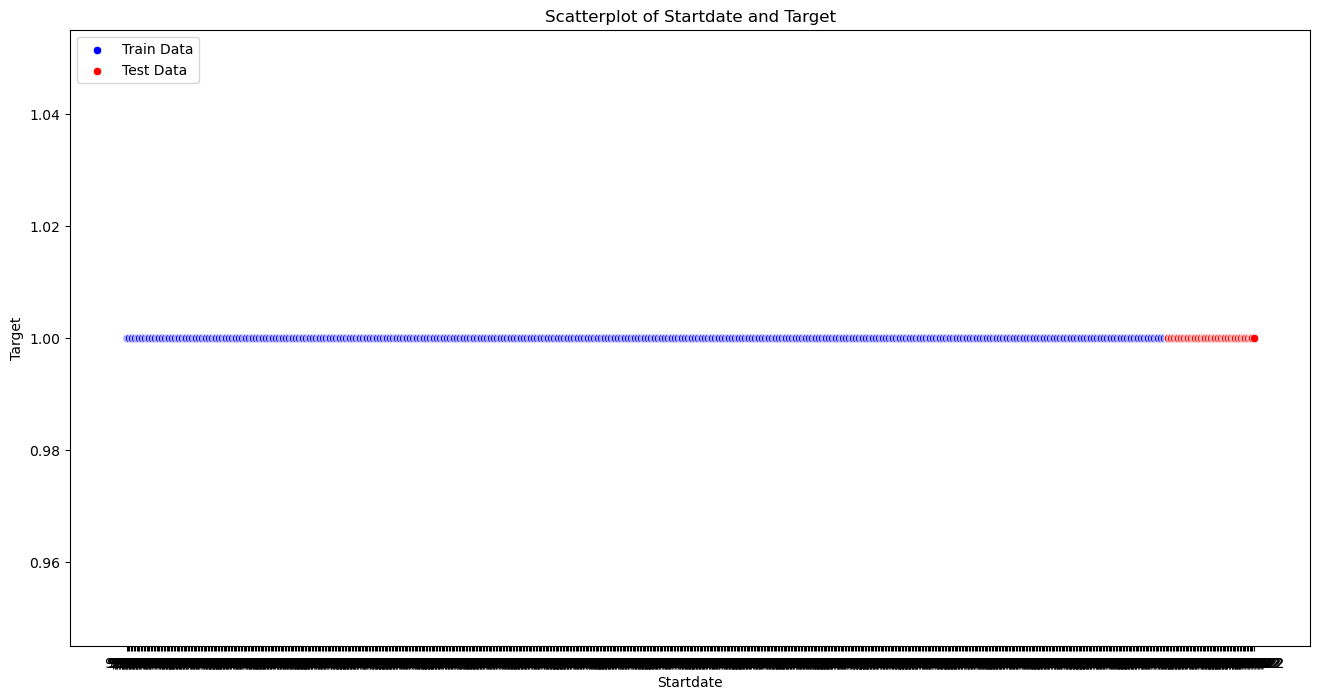

In [15]:
# create a scatterplot using seaborn and matplotlib
fig, ax = plt.subplots(figsize=(16, 8))
sb.scatterplot(x=train_df.startdate, y=1, color='blue', label='Train Data', ax=ax)
sb.scatterplot(x=test_df.startdate, y=1, color='red', label='Test Data', ax=ax)

# add labels and a title to the plot
ax.set_title('Scatterplot of Startdate and Target')
ax.set_xlabel('Startdate')
ax.set_ylabel('Target')
ax.legend(loc='upper left')

# display the plot
plt.show()


**Based on the graph above the train data was from 2014 - 2016 and the test data is from 2022. There is a big time gap between the train and test data.**

## Analyising the distribution of values in both the train and test dataset

In [16]:
def dist_of_train_test_features(train_df, test_df, feature):
    # Analyse the distribution of values in the training dataset
    plt.figure(figsize=(16, 5))
    sb.displot(data=train_df, x=feature, kind='kde', label='Train Data')

    # Analyse the distribution of values in the testing dataset
    plt.figure(figsize=(16, 5))
    sb.displot(data=test_df, x=feature, kind='kde', label='Test Data')
# dist_of_train_test_features(train_df, test_df, 'nmme0-tmp2m-34w__nmme0mean')
#plt.show()

In [17]:
cc_train.shape

(375734, 246)

In [18]:
cc_train.describe()

,index,lat,lon,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,nmme0-tmp2m-34w__gfdlflora0,...,wind-vwnd-925-2010-11,wind-vwnd-925-2010-12,wind-vwnd-925-2010-13,wind-vwnd-925-2010-14,wind-vwnd-925-2010-15,wind-vwnd-925-2010-16,wind-vwnd-925-2010-17,wind-vwnd-925-2010-18,wind-vwnd-925-2010-19,wind-vwnd-925-2010-20
count,375734.000000,375734.000000,375734.000000,375734.000000,375734.000000,375734.000000,359800.000000,375734.000000,375734.000000,375734.000000,...,375734.000000,375734.000000,375734.000000,375734.000000,375734.000000,375734.000000,375734.000000,375734.000000,375734.000000,375734.000000
mean,187866.500000,0.592766,0.517964,276.744049,10.801681,12.726736,10.099324,11.638229,10.733886,11.772648,...,-1.209959,-8.109917,6.800684,19.251972,-17.697563,-9.846868,-6.231860,16.014360,10.489945,11.296336
std,108465.207359,0.251744,0.272059,198.085175,10.952416,11.073553,10.339626,10.574276,9.403434,10.689967,...,37.317333,36.201508,38.458878,25.288525,31.946749,34.164677,27.050356,25.847456,25.070435,25.113214
min,0.000000,0.000000,0.000000,-2.310000,-14.960000,-14.970000,-11.720000,-17.559999,-13.720000,-13.330000,...,-94.570000,-89.940002,-64.870003,-39.279999,-100.559998,-106.080002,-93.980003,-52.610001,-66.110001,-57.610001
25%,93933.250000,0.409091,0.300000,104.062498,1.550000,3.650000,1.640000,3.080000,3.390000,2.970000,...,-27.200001,-33.349998,-19.650000,1.960000,-40.029999,-32.169998,-20.170000,-0.360000,-6.790000,-5.570000
50%,187866.500000,0.590909,0.533333,250.320007,9.950000,11.890000,9.490000,11.600000,10.890000,11.280000,...,-3.200000,-9.390000,2.330000,20.049999,-16.709999,-8.560000,-6.030000,18.650000,11.860000,11.650000
75%,281799.750000,0.818182,0.766667,420.010010,20.230000,22.110001,18.740000,20.360001,18.330000,20.299999,...,24.940001,17.959999,28.660000,35.090000,4.390000,10.500000,11.630000,31.209999,29.040001,29.180000
max,375733.000000,1.000000,1.000000,1185.140015,36.080002,36.029999,33.389999,34.639999,35.750000,38.349998,...,113.919998,96.550003,106.419998,91.760002,56.549999,83.889999,64.849998,90.389999,76.889999,88.660004


In [19]:
cc_test.shape

(31354, 245)

In [20]:
cc_sample.describe()

,contest-tmp2m-14d__tmp2m,index
count,31354.000000,31354.000000
mean,25.006322,391410.500000
std,2.891139,9051.264507
min,20.000011,375734.000000
25%,22.503063,383572.250000
50%,25.030905,391410.500000
75%,27.511672,399248.750000
max,29.997898,407087.000000


# Visualizing the target variable
`contest-tmp2m-14d__tmp2m`

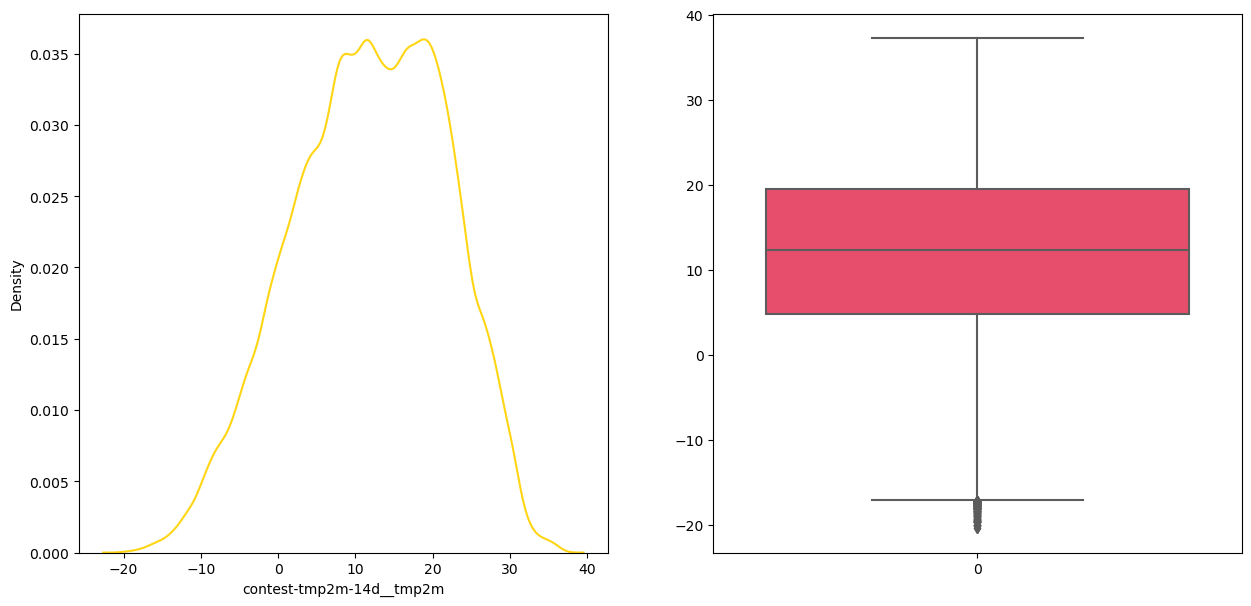

In [21]:
def target_var_visualized():
  plt.figure(figsize=(15,7))
  plt.subplot(121)
  sb.kdeplot(cc_train['contest-tmp2m-14d__tmp2m'], color = "#ffd514")
  plt.subplot(122)
  sb.boxplot(data=cc_train['contest-tmp2m-14d__tmp2m'], color = "#ff355d")
target_var_visualized()

## Displaying the distribution of the target variable in the train and test

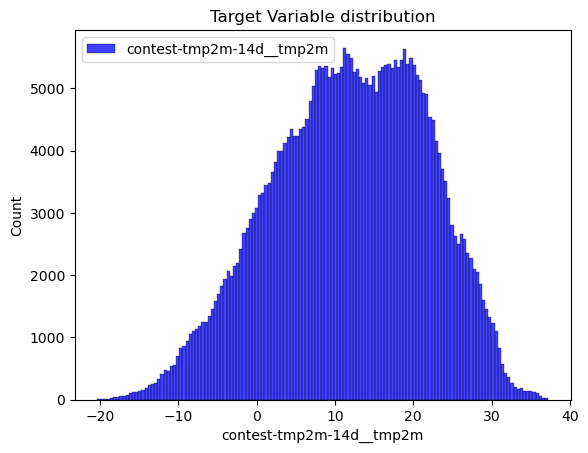

In [22]:
def histogram_plot(data, label, title):
    sb.histplot(data, color='blue', label=label)
    plt.legend()
    plt.title(title)
    plt.show()
histogram_plot(data=cc_train['contest-tmp2m-14d__tmp2m'], label="contest-tmp2m-14d__tmp2m", title="Target Variable distribution")

**The target variable is not in the test dataset**

### Simple for loop to list out the features from the train dataset

In [23]:
'''
test_col = cc_test.columns
count = 0
for name in test_col:
  if count % 50 == 0:
    print()
  print(name + ', ', end='')
  count += 1
'''

"\ntest_col = cc_test.columns\ncount = 0\nfor name in test_col:\n  if count % 50 == 0:\n    print()\n  print(name + ', ', end='')\n  count += 1\n"

In [24]:
cc_train.columns[cc_train.isna().any()].tolist()

['nmme0-tmp2m-34w__ccsm30',
 'nmme-tmp2m-56w__ccsm3',
 'nmme-prate-34w__ccsm3',
 'nmme0-prate-56w__ccsm30',
 'nmme0-prate-34w__ccsm30',
 'nmme-prate-56w__ccsm3',
 'nmme-tmp2m-34w__ccsm3',
 'ccsm30']

In [25]:
cc_test.columns[cc_test.isna().any()].tolist()

[]

In [26]:
cc_sample.columns[cc_sample.isna().any()].tolist()

[]

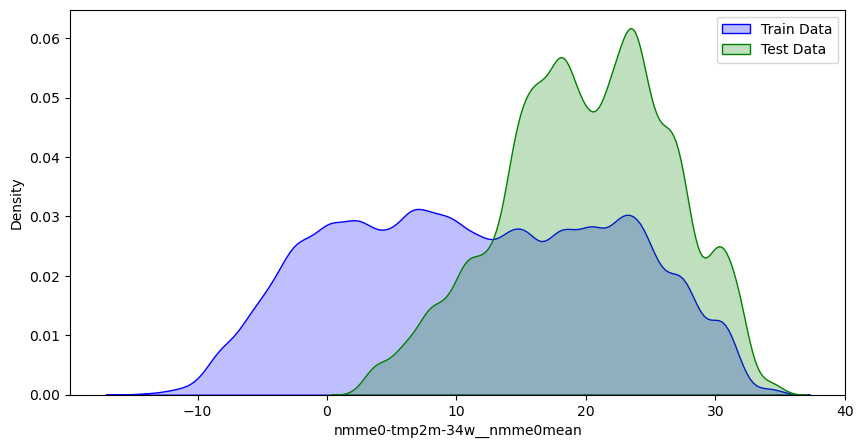

In [27]:
def train_test_dist(train, test):
    fig, ax = plt.subplots(figsize = (10, 5))
    sb.kdeplot(data=train,  color='blue', fill=True, ax=ax, label="Train Data")
    sb.kdeplot(data=test, color='green', fill=True, ax=ax, label="Test Data")
    plt.legend()
    plt.show()
    
#train_target = cc_train['contest-tmp2m-14d__tmp2m']
#test_target = cc_test['contest-tmp2m-14d__tmp2m']
train_target = cc_train['nmme0-tmp2m-34w__nmme0mean']
test_target = cc_test['nmme0-tmp2m-34w__nmme0mean']
train_test_dist(train_target, test_target)

# Visualising Categorical columns

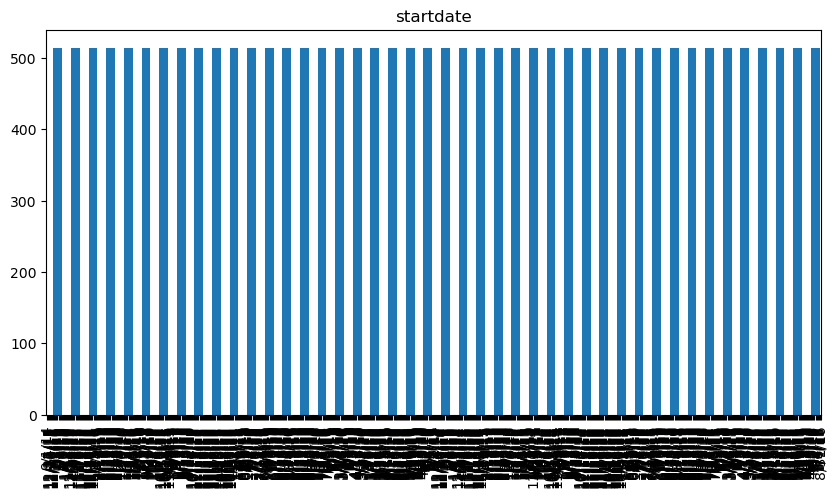

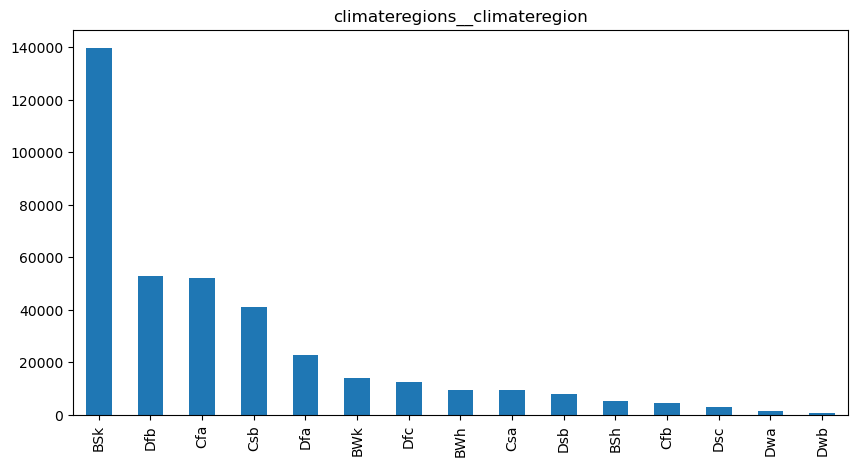

In [28]:

# Plot bar plots for all categorical columns
for column in cc_train.select_dtypes(include=['object']).columns:
    cc_train[column].value_counts().plot(kind='bar', figsize=(10,5))
    plt.title(column)
    plt.show()
    

In [29]:
'''
def plot_boxplots(data, target_column):
    num_cols = data.select_dtypes(exclude=['object']).columns
    for col in num_cols:
        plt.figure(figsize=(10, 5))
        sb.boxplot(x=target_column, y=col, data=data)
        plt.title(col + " vs " + target_column)
        plt.show()
plot_boxplots(cc_train, 'contest-tmp2m-14d__tmp2m')
'''


'\ndef plot_boxplots(data, target_column):\n    num_cols = data.select_dtypes(exclude=[\'object\']).columns\n    for col in num_cols:\n        plt.figure(figsize=(10, 5))\n        sb.boxplot(x=target_column, y=col, data=data)\n        plt.title(col + " vs " + target_column)\n        plt.show()\nplot_boxplots(cc_train, \'contest-tmp2m-14d__tmp2m\')\n'

# Visualising Numerical Columns

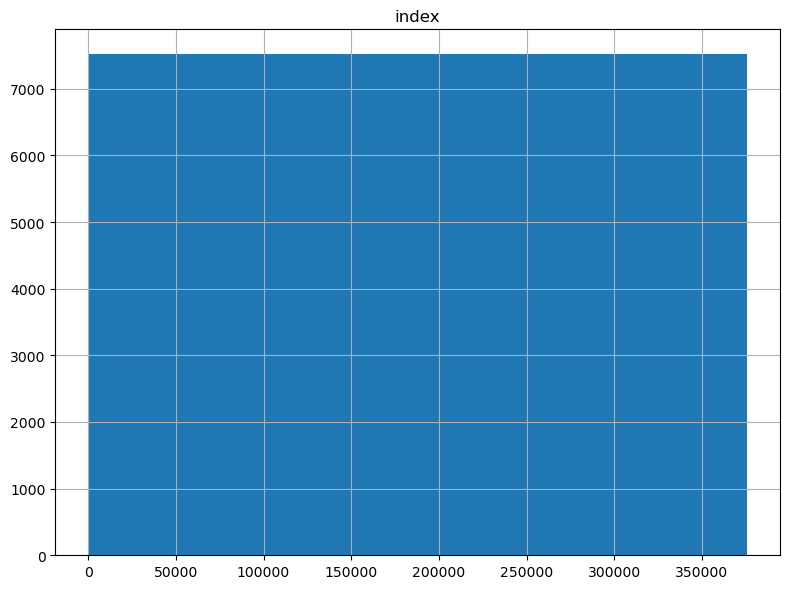

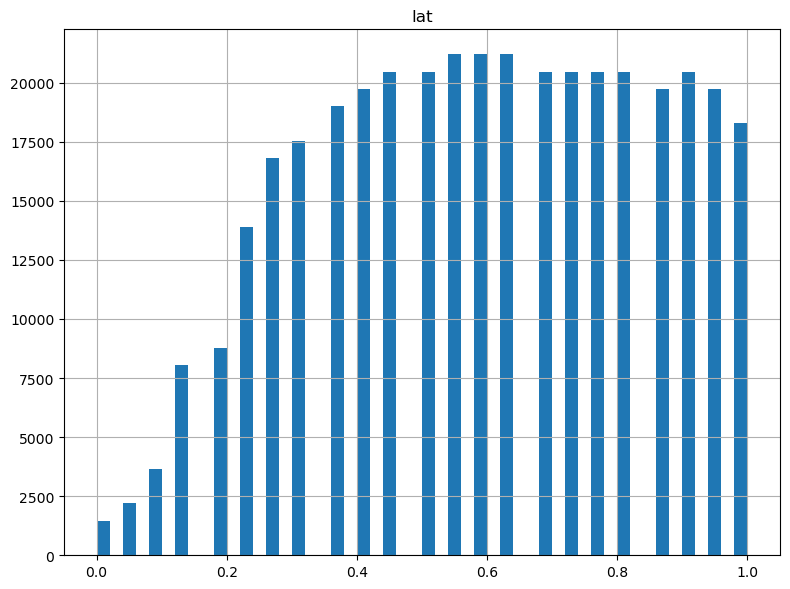

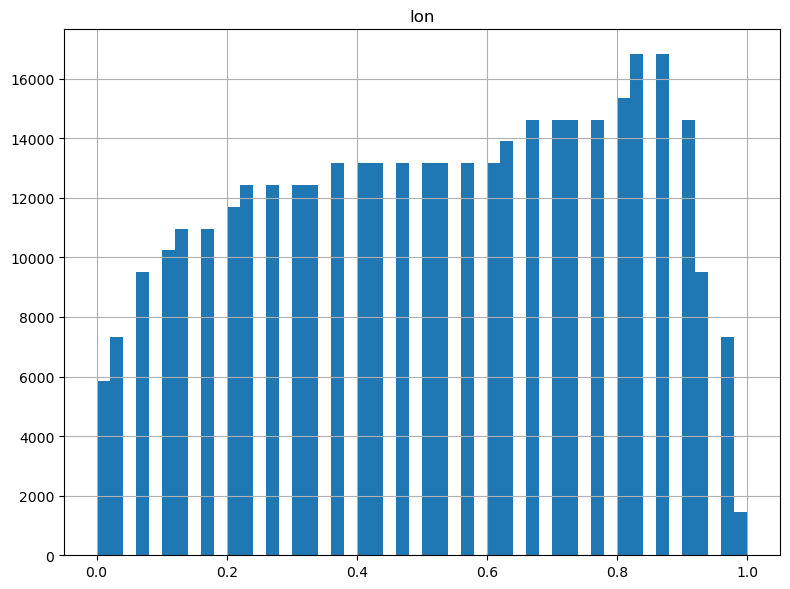

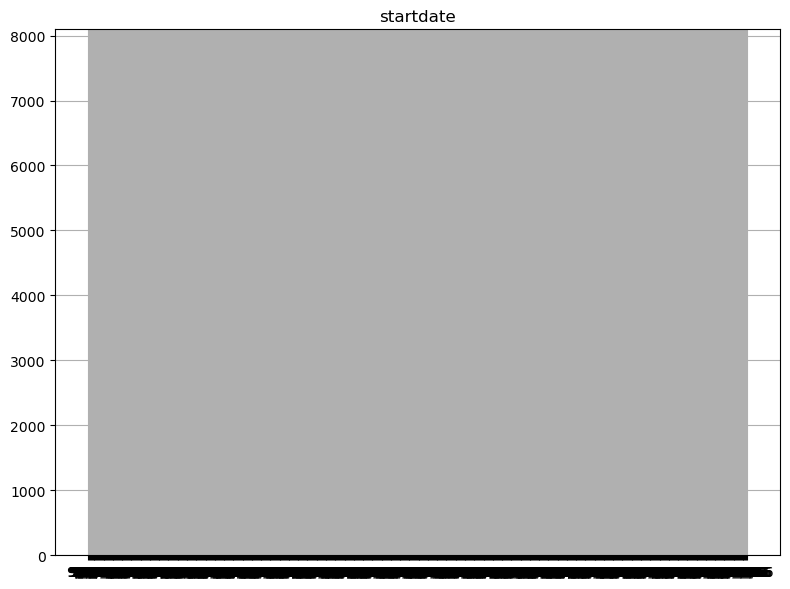

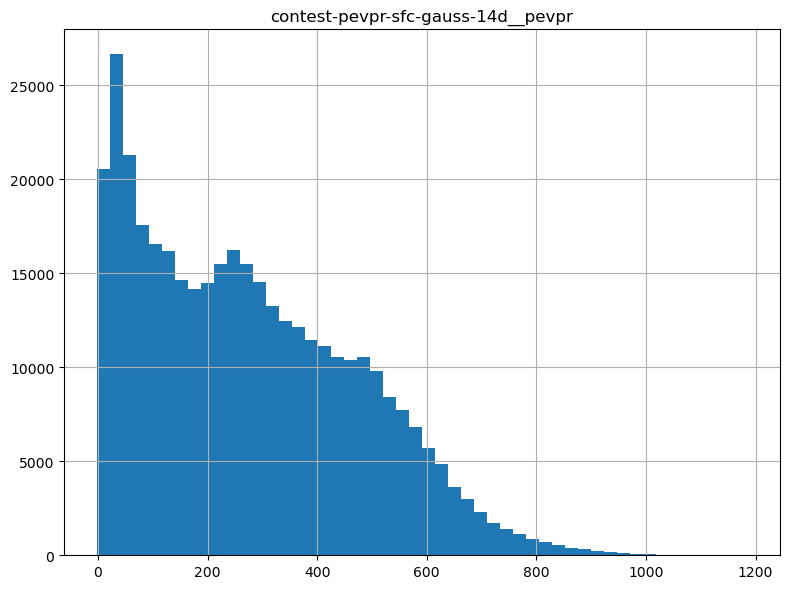

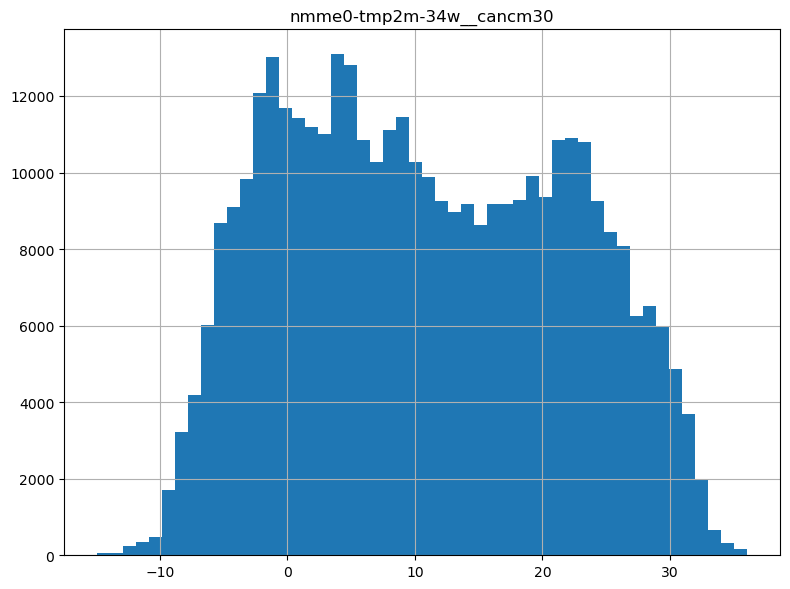

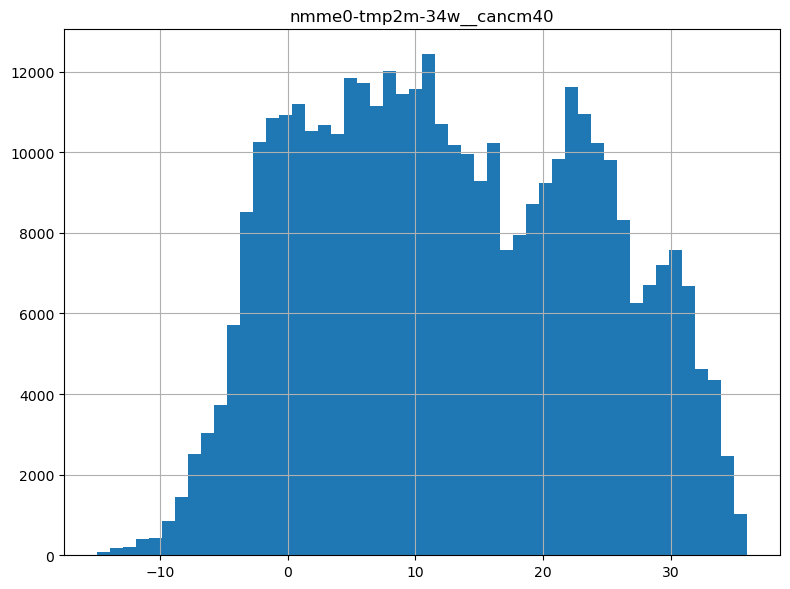

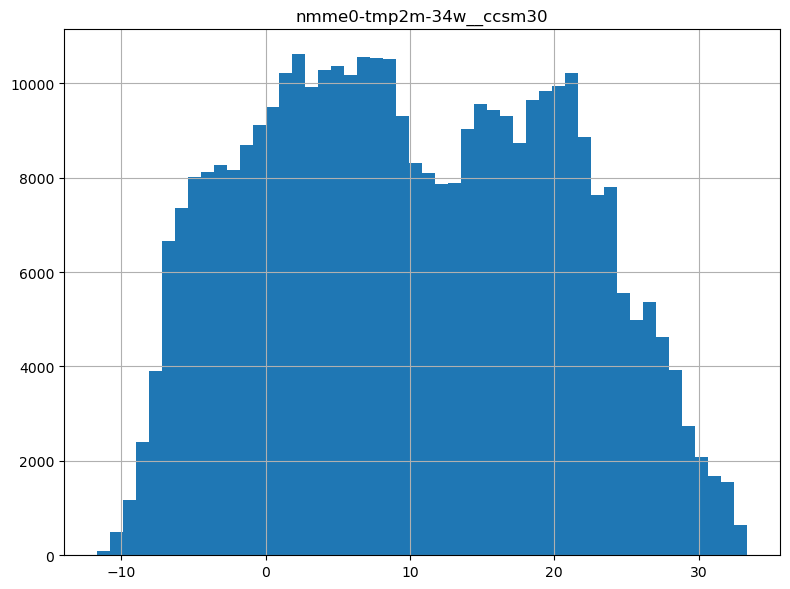

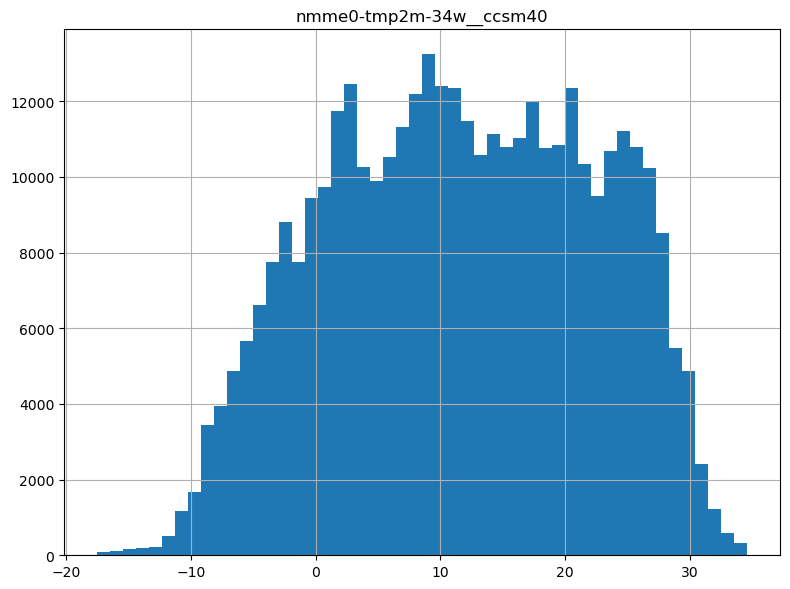

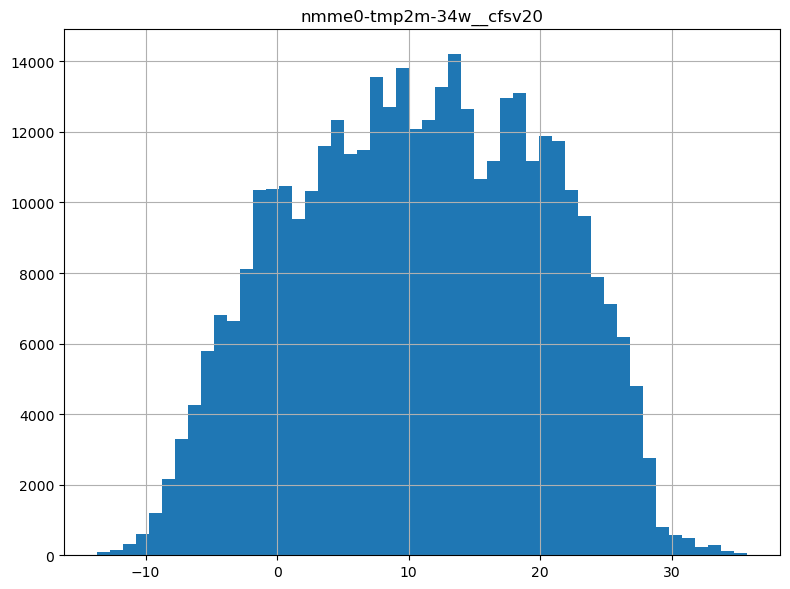

In [30]:
# Plot histograms for all numerical columns
num_cols = cc_train.columns
def plot_histograms(data, column_list):
    """
    This function plots histograms based on the number of columns and data provided.
    
    Parameters
    ----------
    data : pandas dataframe
        The data to be plotted.
    column_list : a list
        The list of 10 numerical column names from the dataset..
    
    Returns
    -------
    void
        Displays histograms from matplotlib.
        The histograms that are being plotted are frequency histograms 
        for the numerical columns specified in the column_list parameter .
    """
    num_cols = column_list
    for col in num_cols:
        plt.figure(figsize=(8, 6))
        data[col].hist(bins=50)
        plt.title(col)
        plt.tight_layout()
        plt.show()
        
plot_histograms(cc_train, num_cols[:10])
#plt.show()

# Null Imputation

In [31]:
cc_train['nmme0-prate-34w__ccsm30'] = cc_train['nmme0-prate-34w__ccsm30'].fillna(cc_train['nmme0-prate-34w__ccsm30'].mean())
cc_train['nmme0-tmp2m-34w__ccsm30'] = cc_train['nmme0-tmp2m-34w__ccsm30'].fillna(cc_train['nmme0-tmp2m-34w__ccsm30'].mean())
cc_train['ccsm30'] = cc_train['ccsm30'].fillna(cc_train['ccsm30'].mean())
cc_train['nmme0-prate-56w__ccsm30'] = cc_train['nmme0-prate-56w__ccsm30'].fillna(cc_train['nmme0-prate-56w__ccsm30'].mean())
cc_train['nmme-tmp2m-56w__ccsm3'] = cc_train['nmme-tmp2m-56w__ccsm3'].fillna(cc_train['nmme-tmp2m-56w__ccsm3'].mean())
cc_train['nmme-prate-56w__ccsm3'] = cc_train['nmme-prate-56w__ccsm3'].fillna(cc_train['nmme-prate-56w__ccsm3'].mean())
cc_train['nmme-tmp2m-34w__ccsm3'] = cc_train['nmme-tmp2m-34w__ccsm3'].fillna(cc_train['nmme-tmp2m-34w__ccsm3'].mean())
cc_train['nmme-prate-34w__ccsm3'] = cc_train['nmme-prate-34w__ccsm3'].fillna(cc_train['nmme-prate-34w__ccsm3'].mean())

# Feature Engineering

In [32]:
cc_train['year']=pd.DatetimeIndex(cc_train['startdate']).year 
cc_train['month']=pd.DatetimeIndex(cc_train['startdate']).month 
cc_train['day']=pd.DatetimeIndex(cc_train['startdate']).day
cc_test['year']=pd.DatetimeIndex(cc_test['startdate']).year 
cc_test['month']=pd.DatetimeIndex(cc_test['startdate']).month 
cc_test['day']=pd.DatetimeIndex(cc_test['startdate']).day

# Data Preproccessing

In [33]:
def location_feature(train, test):
    # Reference: https://www.kaggle.com/code/flaviafelicioni/wids-2023-different-locations-train-test-solved
    scale = 14
    train.loc[:,'lat']=round(train.lat,scale)
    train.loc[:,'lon']=round(train.lon,scale)
    test.loc[:,'lat']=round(test.lat,scale)
    test.loc[:,'lon']=round(test.lon,scale)
    
    train_and_test = pd.concat([train, test], axis=0)
    train_and_test['loc_group'] = train_and_test.groupby(['lat', 'lon']).ngroup()
    print(f'{train_and_test.loc_group.nunique()} unique locations')
    
    train = train_and_test.iloc[:len(train)]
    test = train_and_test.iloc[len(train):].drop(target, axis=1)
    
    return train, test

def cat_encode(train, test):
    # encoding the categorical feature in the train and test data set
    # using OneHotEncoder
    ohe = OneHotEncoder()
    train_encoded = ohe.fit_transform(train[['climateregions__climateregion']])
    test_encoded = ohe.transform(test[['climateregions__climateregion']])
    
    train = train.drop(['climateregions__climateregion'], axis=1)
    test = test.drop(['climateregions__climateregion'], axis=1)
    
    train_encoded = pd.DataFrame(train_encoded.toarray(), columns=ohe.get_feature_names_out(['climateregions__climateregion']))
    test_encoded = pd.DataFrame(test_encoded.toarray(), columns=ohe.get_feature_names_out(['climateregions__climateregion']))
    
    train = pd.concat([train, train_encoded], axis=1)
    test = pd.concat([test, test_encoded], axis=1)
    
    return train, test

    
def fill_na_rows(dataset):
    # Find the columns with missing values
    columns_with_missing_values = dataset.columns[dataset.isnull().any()].tolist()
    
    # Impute the missing values with the mean value of that column
    for col in columns_with_missing_values:
        dataset[col].fillna(dataset[col].mean(), inplace=True)
        
    return dataset

def create_new_feat(dataset):
    dataset['year']=pd.DatetimeIndex(dataset['startdate']).year 
    dataset['month']=pd.DatetimeIndex(dataset['startdate']).month 
    dataset['day']=pd.DatetimeIndex(dataset['startdate']).day
    return dataset

def feature_engineering(origin_train, origin_test):
    train, test = origin_train, origin_test
    train = fill_na_rows(train)
    train = create_new_feat(train)
    test = create_new_feat(test)
    train, test = cat_encode(train, test)
    irrelevant_cols = ['index', 'startdate','contest-tmp2m-14d__tmp2m', 'climateregions__climateregion']
    features = [col for col in train.columns if col not in irrelevant_cols]
    #features = [col for col in train.columns]
    X = train[features]
    X_test = test[features]
    y = train['contest-tmp2m-14d__tmp2m']
    # Initialize the scaler
    #scaler = MinMaxScaler()

    # Fit the scaler to the train data
    #scaler.fit(X)

    # Transform the train data
    #X_train_scaled = scaler.transform(X)

    # Transform the test data
    #X_test_scaled = scaler.transform(X_test)
    
    return X, y, X_test


    
    

# Machine Learning Model
## RandomForestRegressor

Random Forest Regressor is a commonly used machine learning algorithm for regression problems and was chosen in this case because:

- It can handle both linear and non-linear relationships between features and target variables.

- It can handle missing data and is robust to noisy data.

- It is an ensemble method, which means it combines multiple decision trees to produce a more accurate and stable prediction.

- It can provide feature importance scores, which can be useful in identifying the most important features in the data.

- It is easy to implement and provides good results out-of-the-box, especially for large datasets with a large number of features.

These properties make Random Forest Regressor a good choice for a first attempt at solving this regression problem, and it can be a good starting point for further tuning and optimization

# Splittin the data set to train the model

Target variable: `contest-tmp2m-14d__tmp2m`

[WiDS Datathon Challenge](https://www.kaggle.com/competitions/widsdatathon2023/data)

Definition of target variable: 
- the arithmetic mean of the max and min observed temperature over the next 14 days for each location and start date, is provided

Evaluation Metric:

[Evaluation Reference](https://www.kaggle.com/competitions/widsdatathon2023/overview/evaluation)

Root Mean Squared Error (RMSE)

In [34]:
target="contest-tmp2m-14d__tmp2m"
cc_test_copy = cc_test.copy()

In [35]:
# Split the data into training and test sets
X, y, X_test = feature_engineering(cc_train.copy(), cc_test.copy())



# Checking Correlation

In [36]:
## Identify correlated features to drop that fall above a correlation threshold 
## https://goodboychan.github.io/python/datacamp/machine_learning/2020/07/08/02-Feature-selection-I-selecting-for-feature-information.html 

def identify_correlated(df, threshold):
    corr_matrix = df.corr().abs()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    reduced_corr_matrix = corr_matrix.mask(mask)
    features_to_drop = [c for c in reduced_corr_matrix.columns if any(reduced_corr_matrix[c] > threshold)]
    return features_to_drop

In [37]:
# afterwards i should print out the columns that are of high importance from the models
# perform PCA and see if it determines the same features as the corr_matrix
# at.96 the score is ~1.24 (~51 columns dropped)
# at .70 the score is ~1.4 (~100+ columns dropped)
# at .80 the score is ~0.968 (100 columns dropped) - but why were these columns so unimportant that dropping it had a better outcome as compared to the other trials with .95 and .70 ?
# **Besides the fact that they were highly correlated - at .70 had more columns but dropping the columns identifed at .70 had a worse score than .80
features_to_drop = identify_correlated(cc_train, .80)

In [38]:
print(len(features_to_drop))
print(features_to_drop)

100
['index', 'contest-pevpr-sfc-gauss-14d__pevpr', 'nmme0-tmp2m-34w__cancm30', 'nmme0-tmp2m-34w__cancm40', 'nmme0-tmp2m-34w__ccsm30', 'nmme0-tmp2m-34w__ccsm40', 'nmme0-tmp2m-34w__cfsv20', 'nmme0-tmp2m-34w__gfdlflora0', 'nmme0-tmp2m-34w__gfdlflorb0', 'nmme0-tmp2m-34w__gfdl0', 'nmme0-tmp2m-34w__nasa0', 'nmme0-tmp2m-34w__nmme0mean', 'contest-wind-h10-14d__wind-hgt-10', 'nmme-tmp2m-56w__cancm3', 'nmme-tmp2m-56w__cancm4', 'nmme-tmp2m-56w__ccsm3', 'nmme-tmp2m-56w__ccsm4', 'nmme-tmp2m-56w__cfsv2', 'nmme-tmp2m-56w__gfdl', 'nmme-tmp2m-56w__gfdlflora', 'nmme-tmp2m-56w__gfdlflorb', 'nmme-tmp2m-56w__nasa', 'nmme-tmp2m-56w__nmmemean', 'nmme-prate-34w__cancm3', 'nmme-prate-34w__cancm4', 'nmme-prate-34w__ccsm3', 'nmme-prate-34w__ccsm4', 'nmme-prate-34w__cfsv2', 'nmme-prate-34w__gfdl', 'nmme-prate-34w__gfdlflora', 'nmme-prate-34w__gfdlflorb', 'nmme-prate-34w__nasa', 'nmme-prate-34w__nmmemean', 'contest-wind-h100-14d__wind-hgt-100', 'nmme0-prate-56w__cancm30', 'nmme0-prate-56w__cancm40', 'nmme0-prate-

In [39]:
remove_feature = ['index', 'contest-tmp2m-14d__tmp2m']
features_to_drop_v1 = [ele for ele in features_to_drop if ele not in remove_feature]
features_to_drop_v1

['contest-pevpr-sfc-gauss-14d__pevpr',
 'nmme0-tmp2m-34w__cancm30',
 'nmme0-tmp2m-34w__cancm40',
 'nmme0-tmp2m-34w__ccsm30',
 'nmme0-tmp2m-34w__ccsm40',
 'nmme0-tmp2m-34w__cfsv20',
 'nmme0-tmp2m-34w__gfdlflora0',
 'nmme0-tmp2m-34w__gfdlflorb0',
 'nmme0-tmp2m-34w__gfdl0',
 'nmme0-tmp2m-34w__nasa0',
 'nmme0-tmp2m-34w__nmme0mean',
 'contest-wind-h10-14d__wind-hgt-10',
 'nmme-tmp2m-56w__cancm3',
 'nmme-tmp2m-56w__cancm4',
 'nmme-tmp2m-56w__ccsm3',
 'nmme-tmp2m-56w__ccsm4',
 'nmme-tmp2m-56w__cfsv2',
 'nmme-tmp2m-56w__gfdl',
 'nmme-tmp2m-56w__gfdlflora',
 'nmme-tmp2m-56w__gfdlflorb',
 'nmme-tmp2m-56w__nasa',
 'nmme-tmp2m-56w__nmmemean',
 'nmme-prate-34w__cancm3',
 'nmme-prate-34w__cancm4',
 'nmme-prate-34w__ccsm3',
 'nmme-prate-34w__ccsm4',
 'nmme-prate-34w__cfsv2',
 'nmme-prate-34w__gfdl',
 'nmme-prate-34w__gfdlflora',
 'nmme-prate-34w__gfdlflorb',
 'nmme-prate-34w__nasa',
 'nmme-prate-34w__nmmemean',
 'contest-wind-h100-14d__wind-hgt-100',
 'nmme0-prate-56w__cancm30',
 'nmme0-prate-56w__ca

In [40]:
cc_train_reduced = pd.DataFrame(X.drop(features_to_drop_v1, axis=1))
cc_test_reduced = pd.DataFrame(X_test.drop(features_to_drop_v1, axis=1))
print("Dropped features that are highly correlated")

Dropped features that are highly correlated


def ensemble_predict(xgboost_preds, lightgbm_preds):
    # combine the predictions of the two models
    combined_preds = np.mean([xgboost_preds, lightgbm_preds], axis=0)
    return combined_preds

In [41]:
X_train, X_test_tts, y_train, y_test = train_test_split(cc_train_reduced, y, test_size=0.33, random_state=42)
print("Split the dataset for training successfully")

Split the dataset for training successfully


# Using RandomForestRegressor

**Training and test performance**

In [42]:
'''
# Train the Random Forest Regressor
params = {
    'n_estimators': 5000,
    'max_depth': 10,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_features': 'sqrt',
    'bootstrap': True,
    'oob_score': True
}
regr_rfr = RandomForestRegressor(**params)
regr_rfr.fit(X_train, y_train)
# make predictions on the test data
y_pred_rfr = regr_rfr.predict(X_test_tts)

# calculate the RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rfr))
print("RMSE:", rmse)
'''

'\n# Train the Random Forest Regressor\nparams = {\n    \'n_estimators\': 5000,\n    \'max_depth\': 10,\n    \'min_samples_split\': 2,\n    \'min_samples_leaf\': 1,\n    \'max_features\': \'sqrt\',\n    \'bootstrap\': True,\n    \'oob_score\': True\n}\nregr_rfr = RandomForestRegressor(**params)\nregr_rfr.fit(X_train, y_train)\n# make predictions on the test data\ny_pred_rfr = regr_rfr.predict(X_test_tts)\n\n# calculate the RMSE\nrmse = np.sqrt(mean_squared_error(y_test, y_pred_rfr))\nprint("RMSE:", rmse)\n'

In [43]:
# cc_test_pred = regr_rfr.predict(cc_test_reduced)

In [44]:
# cc_test_copy[target] = cc_test_pred
# cc_test_copy[[target,"index"]].to_csv("rfrpredictions.csv",index = False)

# Using XGBoost

*Gradient Boosted Decision Trees*

XGBoost is short for Extreme Gradient Boosting. The implementation is designed for speed and performance. It is an efficient implementation of the stochastic gradient boosting algorithm.

In [45]:
# create a DMatrix from the training data
#dtrain = xgb.DMatrix(data=X_train, label=y_train)
#dtest = xgb.DMatrix(data=X_test)

### Hyperparameters used
These parameters are used to specify the hyperparameters for a gradient boosting tree (GBT) model in the XGBoost library.

- **base_score**: It is the initial prediction score of all instances, global bias.

- **booster**: It specifies which booster to use for model training. The value 'gbtree' indicates that a tree-based booster will be used.

- **tree_method**: It specifies the method used to build the trees. The value 'gpu_hist' means that the histogram-based algorithm is used to build the trees on a GPU.

- **n_estimators**: It is the number of trees in the forest. The higher the number, the more complex the model becomes, but also the longer it takes to train.

- **early_stopping_rounds**: It is used to stop the training process early when the performance on a validation set starts to degrade. The value 50 indicates that training will be stopped if the performance on the validation set does not improve after 50 iterations.

- **objective**: It defines the loss function to be minimized. The value 'reg:squarederror' means that the model will minimize the mean squared error between the predicted and actual values.

- **max_depth**: It is the maximum depth of the trees in the model. The higher the value, the more complex the model becomes. Note: 2 - 8 is recommended, any higher value than 8 would not provide any more benefits.

- **subsample**: It is the fraction of the training instances used to build each tree in the forest. The lower the value, the simpler the model becomes, but also the more prone to overfitting.

- **colsample_bytree**: It is the fraction of the columns used to build each tree in the forest. The lower the value, the simpler the model becomes, but also the more prone to overfitting.

- **learning_rate**: It is the step size at which the optimizer makes updates to the model weights. A lower value means that the model updates more slowly but with less noise.

- **gpu_id**: It is the GPU device id to use for training. The value 0 indicates that the first GPU in the system will be used.

*Can use StratifiedKfold and gridsearhcv to determine the best combinations of parameters.*

> Note 1: I would like to reduce the value of the n_estimators will maintaining the same rmse or better.

> Note 2: Review the learning curve on the training and validation set

In [46]:
'''
# set up parameters for XGBoost
# list of learning_rates to test [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
# n_estimators = [50, 100, 150, 200]
# max_depth = [2, 4, 6, 8]
# param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)
print("Training and predicting using xgboost")
# Define the search space for the hyperparameters
params = {'base_score': 0.5, 
          'booster': 'gbtree',
          'tree_method': 'gpu_hist',
          'n_estimators': 15000,
          'objective': 'reg:squarederror',
          'max_depth': 6,
          'subsample': 0.5,
          'colsample_bytree': 0.5,
          'gamma': 1.4,
          'min_child_weight': 7,
          'learning_rate': 0.01,
          'gpu_id': 0}

reg_xgb = xgb.XGBRegressor(**params)

reg_xgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test_tts, y_test)], verbose=1000)

# get the feature importance scores
importance_scores = reg_xgb.feature_importances_
feature_importances = pd.DataFrame({'feature': X_train.columns, 'importance': importance_scores})
feature_importances.to_csv("xgboostbestparameters.csv")
# sort the features by importance score
feature_importances = feature_importances.sort_values('importance', ascending=False)
print(feature_importances)


# make predictions on the test data
y_pred_xgb = reg_xgb.predict(X_test_tts)

# calculate the RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print("RMSE:", rmse)


cc_test_pred = reg_xgb.predict(cc_test_reduced)
cc_test_copy[target] = cc_test_pred
cc_test_copy[[target,"index"]].to_csv("xgbpredictions.csv",index = False)
print("Finished training and fitting, created xgbpredictions,csv")
'''


'\n# set up parameters for XGBoost\n# list of learning_rates to test [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]\n# n_estimators = [50, 100, 150, 200]\n# max_depth = [2, 4, 6, 8]\n# param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)\nprint("Training and predicting using xgboost")\n# Define the search space for the hyperparameters\nparams = {\'base_score\': 0.5, \n          \'booster\': \'gbtree\',\n          \'tree_method\': \'gpu_hist\',\n          \'n_estimators\': 15000,\n          \'objective\': \'reg:squarederror\',\n          \'max_depth\': 6,\n          \'subsample\': 0.5,\n          \'colsample_bytree\': 0.5,\n          \'gamma\': 1.4,\n          \'min_child_weight\': 7,\n          \'learning_rate\': 0.01,\n          \'gpu_id\': 0}\n\nreg_xgb = xgb.XGBRegressor(**params)\n\nreg_xgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test_tts, y_test)], verbose=1000)\n\n# get the feature importance scores\nimportance_scores = reg_xgb.feature_importances_\nfeature_impo

In [47]:
'''
def objective(trial):
    params = {
        'base_score': 0.5, 
        'booster': 'gbtree',
        'tree_method': 'gpu_hist',
        'n_estimators': 6000,
        'objective': 'reg:squarederror',
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_uniform('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 1.0),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'verbosity': -1,
        'gpu_id': 0
    }

    reg_xgb = xgb.XGBRegressor(**params)

    reg_xgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test_tts, y_test)])

    y_pred_xgb = reg_xgb.predict(X_test_tts)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=15)

print('Number of finished trials:', len(study.trials))
print('Best trial:')
trial = study.best_trial

print(f'  Value: {trial.value:.5f}')
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

best_params = trial.params
reg_xgb = xgb.XGBRegressor(**best_params)
reg_xgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test_tts, y_test)])
y_pred_xgb = reg_xgb.predict(X_test_tts)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print("RMSE:", rmse)

cc_test_pred = reg_xgb.predict(cc_test_reduced)
cc_test_copy[target] = cc_test_pred
cc_test_copy[[target,"index"]].to_csv("xgbpredictions.csv",index = False)
print("Finished training and fitting, created xgbpredictions.csv")
'''

'\ndef objective(trial):\n    params = {\n        \'base_score\': 0.5, \n        \'booster\': \'gbtree\',\n        \'tree_method\': \'gpu_hist\',\n        \'n_estimators\': 6000,\n        \'objective\': \'reg:squarederror\',\n        \'max_depth\': trial.suggest_int(\'max_depth\', 3, 10),\n        \'subsample\': trial.suggest_uniform(\'subsample\', 0.1, 1.0),\n        \'colsample_bytree\': trial.suggest_uniform(\'colsample_bytree\', 0.1, 1.0),\n        \'learning_rate\': trial.suggest_loguniform(\'learning_rate\', 0.001, 0.1),\n        \'verbosity\': -1,\n        \'gpu_id\': 0\n    }\n\n    reg_xgb = xgb.XGBRegressor(**params)\n\n    reg_xgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test_tts, y_test)])\n\n    y_pred_xgb = reg_xgb.predict(X_test_tts)\n\n    rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))\n\n    return rmse\n\nstudy = optuna.create_study(direction=\'minimize\')\nstudy.optimize(objective, n_trials=15)\n\nprint(\'Number of finished trials:\', len(study.

# How does catboost manage

In [48]:
'''
from catboost import CatBoostRegressor
params = {'iterations': 15000,
          'learning_rate': 0.01,
          'depth': 6,
          'l2_leaf_reg': 3,
          'bagging_temperature': 1,
          'border_count': 256,
          'loss_function': 'RMSE',
          'random_seed': None,
          'task_type': 'GPU',
          'verbose': 100}
# Define the CatBoostRegressor object
reg_catboost = CatBoostRegressor(**params)

# Fit the model to the training data
reg_catboost.fit(X_train, y_train, eval_set=(X_train, y_train))

# Generate predictions on the test data
y_pred_catboost = reg_catboost.predict(X_test_tts)

# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred_catboost))
print("RMSE:", rmse)

# Make predictions on the competition test data
cc_test_copy_v2 = cc_test_copy.copy()
cc_test_pred_catb = reg_catboost.predict(cc_test_reduced)
cc_test_copy_v2[target] = cc_test_pred_catb
cc_test_copy_v2[[target, "index"]].to_csv("catboost_predictions.csv", index=False)
'''


'\nfrom catboost import CatBoostRegressor\nparams = {\'iterations\': 15000,\n          \'learning_rate\': 0.01,\n          \'depth\': 6,\n          \'l2_leaf_reg\': 3,\n          \'bagging_temperature\': 1,\n          \'border_count\': 256,\n          \'loss_function\': \'RMSE\',\n          \'random_seed\': None,\n          \'task_type\': \'GPU\',\n          \'verbose\': 100}\n# Define the CatBoostRegressor object\nreg_catboost = CatBoostRegressor(**params)\n\n# Fit the model to the training data\nreg_catboost.fit(X_train, y_train, eval_set=(X_train, y_train))\n\n# Generate predictions on the test data\ny_pred_catboost = reg_catboost.predict(X_test_tts)\n\n# Calculate the RMSE\nrmse = np.sqrt(mean_squared_error(y_test, y_pred_catboost))\nprint("RMSE:", rmse)\n\n# Make predictions on the competition test data\ncc_test_copy_v2 = cc_test_copy.copy()\ncc_test_pred_catb = reg_catboost.predict(cc_test_reduced)\ncc_test_copy_v2[target] = cc_test_pred_catb\ncc_test_copy_v2[[target, "index"]].t

# Using lasso and gradientboosting ensemble

This is taking too long. I need to find a way to speed up

# Using Lasso

lasso = Lasso(alpha=0.005, random_state=1, max_iter=1000)
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test_tts)
cc_test_pred_lasso = lasso.predict(X_test)
cc_test_copy[target] = cc_test_pred_lasso
cc_test_copy[[target,"index"]].to_csv("lassopredictions.csv",index = False)

# Using GradientBoostingRegressor
gbr = GradientBoostingRegressor(n_estimators=10000, learning_rate=0.05, max_depth=4, max_features='sqrt', min_samples_leaf=15, min_samples_split=10, loss='huber', random_state =5)
gbr.fit(X_train, y_train)
y_pred_gbr = gbr.predict(X_test_tts)
cc_test_copy_v2 = cc_test_copy.copy()
cc_test_pred_gbr = gbr.predict(X_test)
cc_test_copy_v2[target] = cc_test_pred_gbr
cc_test_copy_v2[[target, "index"]].to_csv("gbrpredictions.csv", index = False)

# Using LightGBM

## understanding hyperparameters

[Amazon documentation on LightGBM](https://docs.aws.amazon.com/sagemaker/latest/dg/lightgbm-hyperparameters.html)

In [49]:
'''
print("Beginning training and fitting lightgbm model")
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 31,
    'max_depth': 8,
    'learning_rate': 0.03,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'min_child_samples': 50,
    'min_data_in_leaf': 100,
    'subsample_for_bin': 200000,
    'n_estimators': 15000,
    'early_stopping_rounds': 50,
    'device_type': 'gpu'
}

# Create the LightGBM model object
reg_lgb = lgb.LGBMRegressor(**params)

# Fit the model to the training data
reg_lgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test_tts, y_test)], verbose=1000)


# Get feature importances
importance_scores = reg_lgb.feature_importances_
feature_importances = pd.DataFrame({'feature': X_train.columns, 'importance': importance_scores})

# Sort the features by importance score
feature_importances = feature_importances.sort_values('importance', ascending=False)

# Output feature importances to a CSV file
feature_importances.to_csv("lgbm_feature_importances.csv", index=False)

# Generate predictions on the test data
y_pred_lgb = reg_lgb.predict(X_test_tts)

# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred_lgb))
print("RMSE:", rmse)

# Make predictions on the competition test data
cc_test_copy_v2 = cc_test_copy.copy()
cc_test_pred_lgb = reg_lgb.predict(cc_test_reduced)
cc_test_copy_v2[target] = cc_test_pred_lgb
cc_test_copy_v2[[target, "index"]].to_csv("lgbpredictions.csv", index=False)
print("Finished training and fitting lightgbm model, created lgbpredictions.csv and feature_importances.csv")
'''

'\nprint("Beginning training and fitting lightgbm model")\nparams = {\n    \'boosting_type\': \'gbdt\',\n    \'objective\': \'regression\',\n    \'metric\': \'rmse\',\n    \'num_leaves\': 31,\n    \'max_depth\': 8,\n    \'learning_rate\': 0.03,\n    \'feature_fraction\': 0.9,\n    \'bagging_fraction\': 0.8,\n    \'bagging_freq\': 5,\n    \'min_child_samples\': 50,\n    \'min_data_in_leaf\': 100,\n    \'subsample_for_bin\': 200000,\n    \'n_estimators\': 15000,\n    \'early_stopping_rounds\': 50,\n    \'device_type\': \'gpu\'\n}\n\n# Create the LightGBM model object\nreg_lgb = lgb.LGBMRegressor(**params)\n\n# Fit the model to the training data\nreg_lgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test_tts, y_test)], verbose=1000)\n\n\n# Get feature importances\nimportance_scores = reg_lgb.feature_importances_\nfeature_importances = pd.DataFrame({\'feature\': X_train.columns, \'importance\': importance_scores})\n\n# Sort the features by importance score\nfeature_importances = f

In [50]:

'''

def objective(trial):
    params = {
        'boosting_type': 'gbdt', 
        'objective': 'regression', 
        'metric': 'rmse', 
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'num_leaves': trial.suggest_int('num_leaves', 10, 100),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'lambda_l1': trial.suggest_int('lambda_l1', 0, 100),
        'lambda_l2': trial.suggest_int('lambda_l2', 0, 100),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'device_type':'gpu',
        'verbosity': -1,
        'n_estimators': 6000
    }

    reg_lgb = lgb.LGBMRegressor(**params)

    reg_lgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test_tts, y_test)])

    y_pred_lgb = reg_lgb.predict(X_test_tts)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred_lgb))

    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=15)

print('Number of finished trials:', len(study.trials))
print('Best trial:')
trial = study.best_trial

print(f'  Value: {trial.value:.5f}')
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')    

best_params = trial.params
reg_lgb = lgb.LGBMRegressor(**best_params)
reg_lgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test_tts, y_test)])
y_pred_lgb = reg_lgb.predict(X_test_tts)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_lgb))
print("RMSE:", rmse)

cc_test_copy_v2 = cc_test_copy.copy()
cc_test_pred_lgb = reg_lgb.predict(cc_test_reduced)
cc_test_copy_v2[target] = cc_test_pred_lgb
cc_test_copy_v2[[target, "index"]].to_csv("lgbpredictions.csv", index=False)

'''

'\n\ndef objective(trial):\n    params = {\n        \'boosting_type\': \'gbdt\', \n        \'objective\': \'regression\', \n        \'metric\': \'rmse\', \n        \'max_depth\': trial.suggest_int(\'max_depth\', 3, 10),\n        \'num_leaves\': trial.suggest_int(\'num_leaves\', 10, 100),\n        \'learning_rate\': trial.suggest_loguniform(\'learning_rate\', 0.001, 0.1),\n        \'lambda_l1\': trial.suggest_int(\'lambda_l1\', 0, 100),\n        \'lambda_l2\': trial.suggest_int(\'lambda_l2\', 0, 100),\n        \'min_child_weight\': trial.suggest_int(\'min_child_weight\', 1, 10),\n        \'device_type\':\'gpu\',\n        \'verbosity\': -1,\n        \'n_estimators\': 6000\n    }\n\n    reg_lgb = lgb.LGBMRegressor(**params)\n\n    reg_lgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test_tts, y_test)])\n\n    y_pred_lgb = reg_lgb.predict(X_test_tts)\n\n    rmse = np.sqrt(mean_squared_error(y_test, y_pred_lgb))\n\n    return rmse\n\nstudy = optuna.create_study(direction=\'minimiz

cc_test_copy_v2 = cc_test_copy.copy()
cc_test_pred_lgb = reg_lgb.predict(cc_test_reduced)
cc_test_copy_v2[target] = cc_test_pred_lgb
cc_test_copy_v2[[target,"index"]].to_csv("lgbpredictions.csv",index = False)

## Let's try out using Robust Linear regression model from the statsmodel api

---

Robust regression models can be particularly useful for large datasets with many features, where outliers are common and can significantly impact the performance of the model. By using robust regression models, you can improve the reliability of your predictions and reduce the risk of overfitting to noisy or spurious data.

In [51]:
import statsmodels.api as sm

# Fit a robust linear regression model
rlm_model = sm.RLM(y_train, X_train, M=sm.robust.norms.Hampel())
rlm_results = rlm_model.fit(scale_est=sm.robust.scale.HuberScale())

# Print the summary of the model
print(rlm_results.summary())

# Get the predicted values on the test set
y_pred = rlm_results.predict(X_test_tts)

# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)


                                          Robust linear Model Regression Results                                          
Dep. Variable:                                           contest-tmp2m-14d__tmp2m   No. Observations:               251741
Model:                                                                        RLM   Df Residuals:                   251580
Method:                                                                      IRLS   Df Model:                          160
Norm:                                                                      Hampel                                         
Scale Est.:        <statsmodels.robust.scale.HuberScale object at 0x7f9ca782ef10>                                         
Cov Type:                                                                      H1                                         
Date:                                                            Thu, 23 Feb 2023                                         
Time:           

# Using Multi-Layer Perceptron Models

In [52]:
'''
params = {'hidden_layer_sizes': (100,50,10), 
          'activation': 'relu',
          'solver': 'adam',
          'alpha': 0.0001,
          'batch_size': 'auto',
          'learning_rate': 'constant',
          'learning_rate_init': 0.001,
          'max_iter': 200,
          'shuffle': True,
          'random_state': None,
          'tol': 0.0001,
          'verbose': True,
          'warm_start': False,
          'momentum': 0.9,
          'nesterovs_momentum': True,
          'early_stopping': False,
          'validation_fraction': 0.1,
          'beta_1': 0.9,
          'beta_2': 0.999,
          'epsilon': 1e-08}

# Standardize the data using a standard scaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test_tts = scaler.transform(X_test_tts)

reg_mlp = MLPRegressor(**params)

reg_mlp.fit(X_train, y_train)

# make predictions on the test data
y_pred_mlp = reg_mlp.predict(X_test_tts)

# calculate the RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred_mlp))
print("RMSE:", rmse)
# Make predictions on the competition test data
cc_test_copy_v2 = cc_test_copy.copy()

cc_test_pred_mlp = reg_mlp.predict(cc_test_reduced)
cc_test_copy_v2[target] = cc_test_pred_mlp
cc_test_copy_v2[[target,"index"]].to_csv("mlppredictions.csv",index = False)
'''

'\nparams = {\'hidden_layer_sizes\': (100,50,10), \n          \'activation\': \'relu\',\n          \'solver\': \'adam\',\n          \'alpha\': 0.0001,\n          \'batch_size\': \'auto\',\n          \'learning_rate\': \'constant\',\n          \'learning_rate_init\': 0.001,\n          \'max_iter\': 200,\n          \'shuffle\': True,\n          \'random_state\': None,\n          \'tol\': 0.0001,\n          \'verbose\': True,\n          \'warm_start\': False,\n          \'momentum\': 0.9,\n          \'nesterovs_momentum\': True,\n          \'early_stopping\': False,\n          \'validation_fraction\': 0.1,\n          \'beta_1\': 0.9,\n          \'beta_2\': 0.999,\n          \'epsilon\': 1e-08}\n\n# Standardize the data using a standard scaler\nscaler = StandardScaler()\nX_train = scaler.fit_transform(X_train)\nX_test_tts = scaler.transform(X_test_tts)\n\nreg_mlp = MLPRegressor(**params)\n\nreg_mlp.fit(X_train, y_train)\n\n# make predictions on the test data\ny_pred_mlp = reg_mlp.predict(X

cc_test_copy_v2[target]

cc_test_copy[target]

In [53]:
#ensemble_preds = cc_test_copy_v2[target]*0.7+cc_test_copy[target]*0.3

In [54]:
'''
cc_submission = cc_test_copy.copy()
cc_submission[target] = ensemble_preds
cc_submission[[target,"index"]].to_csv('submission.csv', index = False)
'''

'\ncc_submission = cc_test_copy.copy()\ncc_submission[target] = ensemble_preds\ncc_submission[[target,"index"]].to_csv(\'submission.csv\', index = False)\n'